# Challenge : predict conversions 🏆🏆

This notebook shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). 

# Import libraries

In [153]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifierCV, SGDClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)


# Read file with labels

In [154]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [155]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [156]:
data.describe(include = "all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [157]:
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

Conclusions : 
* There are no missing values in this entire dataset
* No need for label encoder as the target is already encoded into 0 and 1
* the columns **new_user**, **country**, **source** are categorical : necessary to encode them (using One Hot Encoder)
* the columns **age** et **total_pages_visited** are quantitative : we should normalize them
* CAUTION : presence of outliers in Age : 123 years old ! 

In [158]:
#filtrer que les ages < 90
data = data[data['age'] < 90]

# Explore dataset

In [159]:
# First of all, is the target variable balanced ? 
print('Percentage of converted persons in the dataset : ' , round(len(data[data['converted'] == 1]) / len(data) , 3) * 100 , '%') # Not at all

print('Unique countries represented: ' , data['country'].unique())
print('Unique source represented: ' , data['source'].unique())

Percentage of converted persons in the dataset :  3.2 %
Unique countries represented:  ['China' 'UK' 'Germany' 'US']
Unique source represented:  ['Direct' 'Ads' 'Seo']


In [160]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

### EDA on user profile analysis

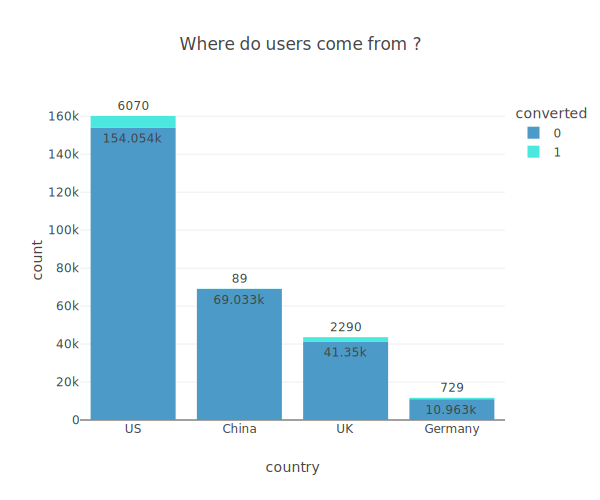

In [168]:
fig1 = px.histogram(data, x = 'country',
            color = 'converted', 
            title="Where do users come from ?", 
            text_auto=True, 
            category_orders=dict(country=["US", "China", "UK", "Germany"])).update_xaxes(categoryorder='total descending')

fig1.update_layout(autosize=True, 
                    width=600,
                    height=500)
fig1.show()

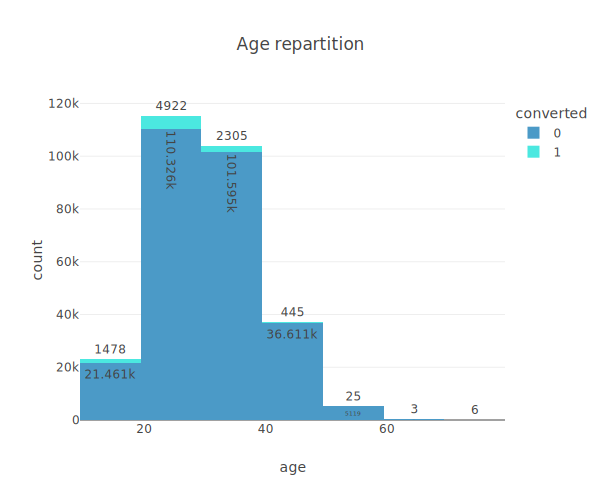

In [162]:
fig2 = px.histogram(data, x ="age", color = "converted",
            title="Age repartition", 
            text_auto=True, 
            nbins=10)

fig2.update_layout(autosize=True, 
                    width=600,
                    height=500)
fig2.show()

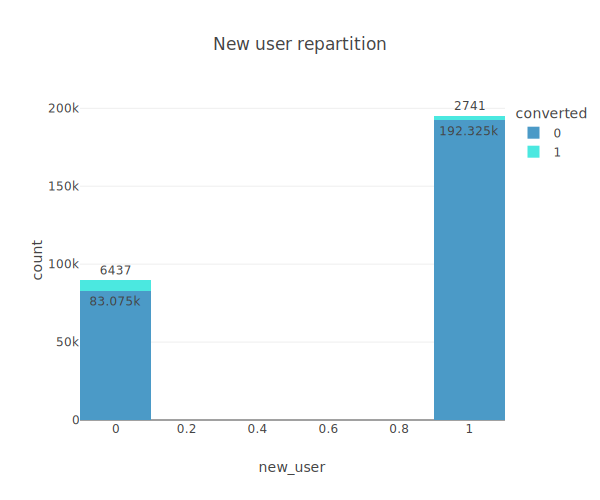

In [166]:
fig3 = px.histogram(data, x="new_user", 
            title="New user repartition", 
            color = 'converted',
            text_auto=True, 
            nbins=10)

fig3.update_layout(autosize=True, 
                    width=600,
                    height=500)
fig3.show()

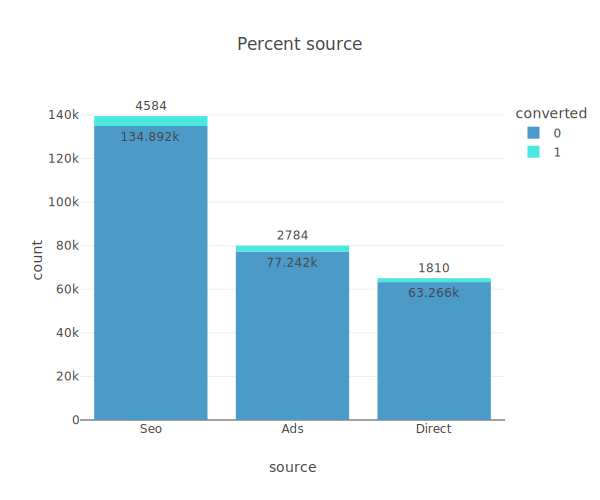

In [167]:
fig4 = px.histogram(data, x = "source",
                    color = "converted", 
            title="Percent source", 
            text_auto=True).update_xaxes(categoryorder='total descending')

fig4.update_layout(autosize=True, 
                    width=600,
                    height=500)
fig4.show()

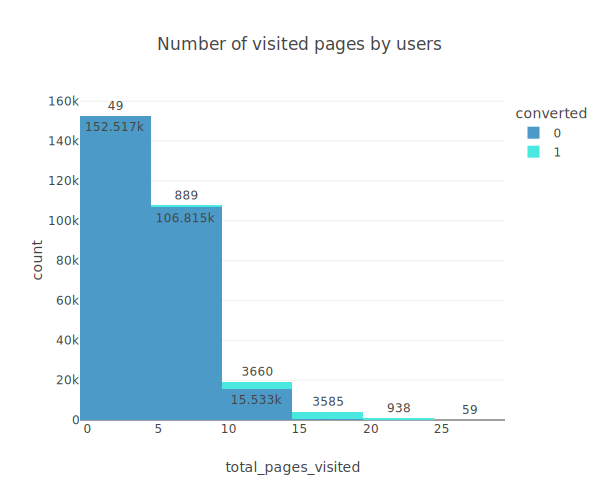

In [152]:
fig5 = px.histogram(data, x = "total_pages_visited", color = "converted", 
            title="Number of visited pages by users", 
            nbins=10,
            text_auto=True).update_xaxes(categoryorder='total descending')

fig5.update_layout(autosize=True, 
                    width=600,
                    height=500)
fig5.show()

# Model trainings

Here we have a classification probem as the targeted value (the conversion rate) is categorical. 
In the template of this project, a baseline model was made by training an univariate logistic regression on the **total_pages_visited**. 
The results obtained were :
- f1-score on train set :  0.6938517686692869
- f1-score on test set :  0.7060240963855423

**The baseline model reaches a f1-score of almost 70%. Now, let's try to beat this score**.

Note : during this project, more than 20 models were trained in order to obtain top-rank position in the leaderboard. Only the two best models are presented here. 


## Preprocessing

In [89]:
# Feature definition :

features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [90]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...


...Done.



In [91]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

num_featureencoder = StandardScaler()
num_features = ['age', 'total_pages_visited']

cat_featureencoder = OneHotEncoder(drop='first')
cat_features = ['country', 'new_user', 'source']

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_featureencoder, num_features),
        ('cat', cat_featureencoder, cat_features)
    ])

print("Preprocessing done")

Encoding categorical features and standardizing numerical features...
Preprocessing done


In [92]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Performing preprocessings on train set...


...Done.
[[-1.51987065 -0.26099836  0.          0.          1.          0.
   0.          1.        ]
 [ 2.2307148   0.03829244  0.          0.          0.          0.
   0.          1.        ]
 [ 1.86775492 -0.56028917  0.          0.          0.          1.
   0.          1.        ]
 [-1.51987065 -1.15887077  0.          0.          1.          0.
   0.          0.        ]
 [-1.03592414  0.33758325  0.          0.          1.          1.
   0.          0.        ]]

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
...Done
[[-0.79395089  2.73190968  0.          0.          0.          1.
   0.          0.        ]
 [ 0.53690202  0.03829244  0.          0.          1.          0.
   1.          0.        ]
 [-0.18901775 -0.26099836  0.          0.          1.          0.
   1.          0.        ]
 [ 0.0529555   0.93616485  0.          0.          0.          1.
   0.          1.        ]
 [-0.67296426  0.93616485  0.    

## Model 1 : multivariate Logistic Regression

In [93]:
# Train model
print("Train model...")
classifier = LogisticRegression(solver = 'saga') 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


### Cross validation and grid-search for best parameters
In order to know if test score and validation score are comparible or not, it is necessary to do a cross validation to obtain the average error on the metric chosen : f1-score.

In this model, it is also possible to do a parameter grid-search in order to define which are the best hyperparameters to use. 

In [94]:
# Cross validation pour avoir une incertitude
scores = cross_val_score(classifier, X_train, Y_train, scoring = "f1", cv=5)


In [95]:
parameters = [{'penalty':['l1', 'l2']},
              {'C':[1, 3, 5, 10, 30]}]



grid_search = GridSearchCV(estimator = classifier,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           verbose=0, error_score = 'raise')


grid_search.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", grid_search.best_params_)
print("Best validation accuracy: ", grid_search.best_score_)
print("...Done.")


...Done.
Best hyperparameters :  {'C': 3}
Best validation accuracy:  0.7627996752564346
...Done.


In [96]:
c= grid_search.best_estimator_

### Prediction and results

In [97]:
c.fit(X_train, Y_train)
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = c.predict(X_train)
print("...Done.")
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = c.predict(X_test)
print("...Done.")
print()

# Concatenate our train and test set to train your best classifier on all data with labels
X_total = np.append(X_train,X_test,axis=0)
Y_total = np.append(Y_train,Y_test)

c.fit(X_total,Y_total)

print("Predictions on entire set...")
Y_total_pred = c.predict(X_total)
print("...Done.")


Predictions on training set...
...Done.

Predictions on test set...
...Done.

Predictions on entire set...
...Done.


### Performance assessment

In [98]:
print('The cross-validated is : ', scores.mean())
print('The standard deviation is : ', scores.std())
print('Value should be between :', round(scores.mean()-scores.std(), 3), "and", round(scores.mean()+scores.std(), 3))
print('')
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print("f1-score on entire set : ", f1_score(Y_total, Y_total_pred))

The cross-validated is :  0.7625518866681835
The standard deviation is :  0.008287808977811947
Value should be between : 0.754 and 0.771

f1-score on train set :  0.7627414163090129
f1-score on test set :  0.7711711711711712
f1-score on entire set :  0.7634914885910903


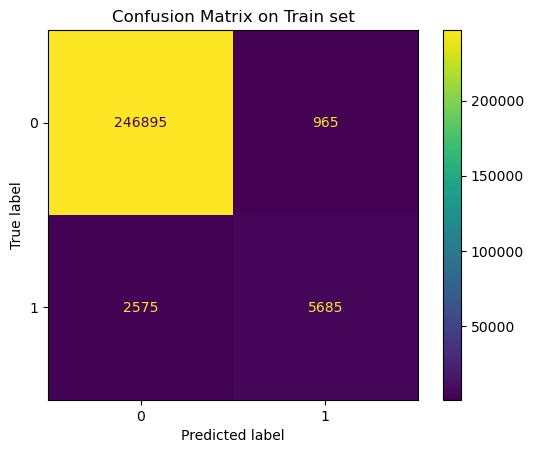

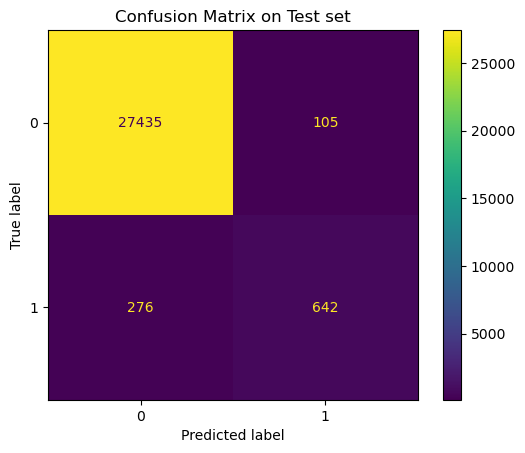

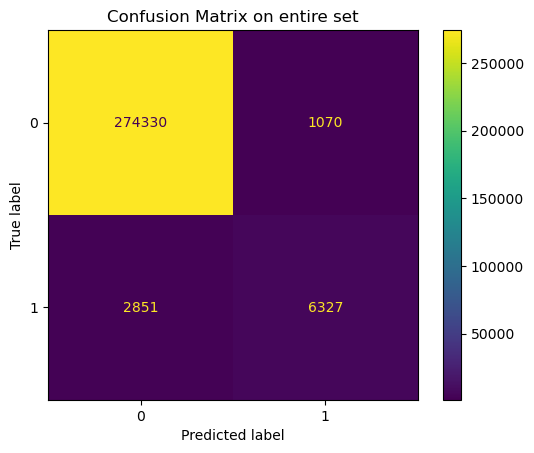

In [99]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on entire set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_total, Y_total, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

**Our model reaches a f1-score of almost 77%.🚀🚀**
The result is already better than the base model.
Let's try and find other ways to ameliorate it.

## Model 2 : SGD classifier
This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

In [171]:
# Train model
print("Train model...")
c = SGDClassifier() 
c.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [172]:
c.feature_names_in_

AttributeError: 'SGDClassifier' object has no attribute 'feature_names_in_'

### Prediction and results

In [101]:
c.fit(X_train, Y_train)
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = c.predict(X_train)
print("...Done.")
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = c.predict(X_test)
print("...Done.")
print()

# Concatenate our train and test set to train your best classifier on all data with labels
X_total = np.append(X_train,X_test,axis=0)
Y_total = np.append(Y_train,Y_test)

c.fit(X_total,Y_total)

print("Predictions on entire set...")
Y_total_pred = c.predict(X_total)
print("...Done.")


Predictions on training set...
...Done.

Predictions on test set...
...Done.

Predictions on entire set...
...Done.


### Performance assessment

In [102]:
print('The cross-validated is : ', scores.mean())
print('The standard deviation is : ', scores.std())
print('Value should be between :', round(scores.mean()-scores.std(), 3), "and", round(scores.mean()+scores.std(), 3))
print('')
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print("f1-score on entire set : ", f1_score(Y_total, Y_total_pred))

The cross-validated is :  0.7625518866681835
The standard deviation is :  0.008287808977811947
Value should be between : 0.754 and 0.771

f1-score on train set :  0.7576169749727965
f1-score on test set :  0.7616136919315404
f1-score on entire set :  0.7690604064005315


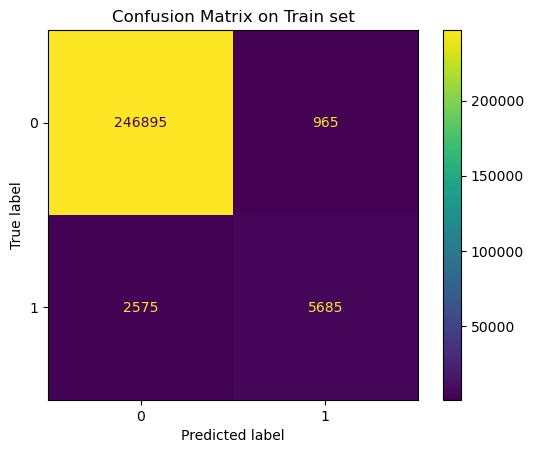

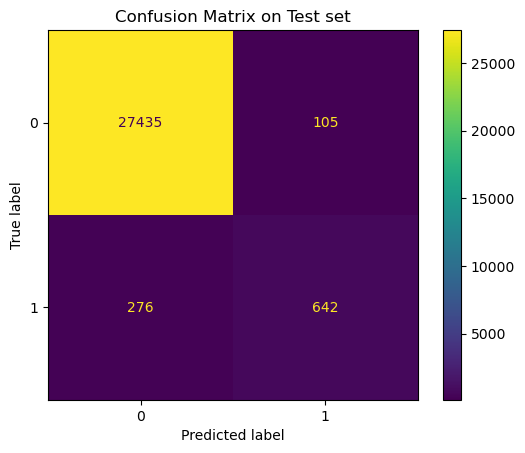

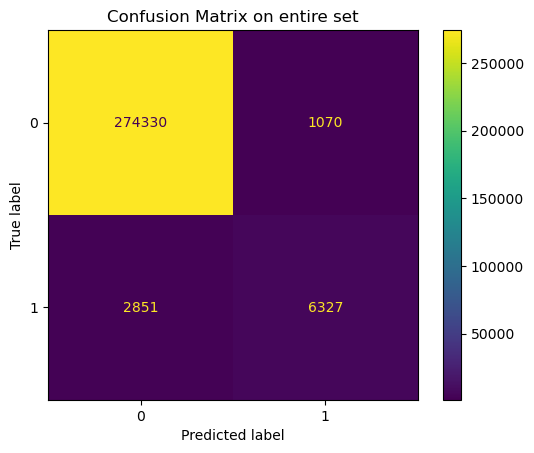

In [103]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on entire set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_total, Y_total, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

## Conclusion

Amongst the 30 models that were trained (not all were detailed in this notebook), I have chosen the two best ones that made it to the leaderboard (rank 1 and rank 6). 
The csv results that ranked 1 are in this folder (conversion_data_test_predictions_CTang-model26.csv).

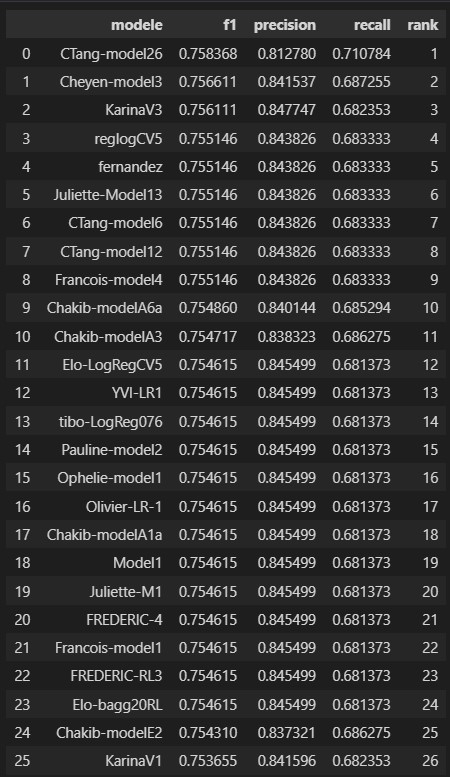


## Analyzing the coefficients and interpreting the result


In [170]:
coefs = np.exp(classifier.coef_)[0] # To display interpretable results
features_names = classifier.feature_names_in_ 
to_plot = pd.DataFrame({'Feature' : features_names , 'Coefficient' : coefs}).sort_values(by='Coefficient' , ascending=True)
assert len(coefs) == len(features_names)


plt.figure(figsize=(15,7))
plt.barh(to_plot['Feature'] , to_plot['Coefficient'] , color='gold' , edgecolor='black')
plt.xlabel('Coefficient value (Multiplication value of the ratio of probability of successes and  probability of failures)')
plt.ylabel('Feature name')
plt.title('Features importances from the optimized logistic regression')
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'